# Homework 8: Dimensionality Reduction and PCA
by Karanraj Chauhan with help from B. Kulis, N. Frumkin and R. Manzelli, and A. Tsiligkardis

## Problem 1: Eigenvectors and Eigenvalues

Compute the eigenvectors and eigenvalues for the following matrices **by hand**. Note: you do not need to simplify square roots, irrational fractions, etc., in case you have any in your answers.

1.
\begin{bmatrix}
  5 & 2 \\
  -3 & 10     
\end{bmatrix}

2.
\begin{bmatrix}
  6 & 5 \\
  7 & 2     
\end{bmatrix}

`Please see` **Solutions problem 1.pdf** `for solutions to this problem`

## Problem 2: Eigenfaces

[Eigenfaces](https://en.wikipedia.org/wiki/Eigenface) is the name given to a set of eigenvectors (principal components) when they are used in the computer vision problem of human face recognition. These eigenvectors/principal components can be derived from the covariance matrix of $X$, where $X$ is a $d$ x $n$ matrix such that each column of $X$ represents an image. (Recall: in lecture, we discussed that one of the ways of interpreting PCA is projecting data onto the $k$ leading eigenvectors of the sample covariance matrix)

**a. Load Image Data(sub)set** Load the numpy array `lfw_funneled_subset.npy` using the [load](https://docs.scipy.org/doc/numpy/reference/generated/numpy.load.html) function from numpy. This numpy array represents a subset of the [LFW Face Database](http://vis-www.cs.umass.edu/lfw/)\[1\]. It is of shape 75 x 250 x 250, representing 75 images of faces of celebrities. Using this, calculate the mean face, i.e. the average of the 75 images. Display this mean face image using the [imshow](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.imshow.html) function from matplotlib.

In [1]:
import pdb
import os
import numpy as np
from PIL import Image
from glob import glob
from matplotlib import pyplot as plt

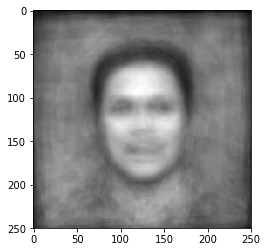

In [2]:
# read in the dataset
images = np.load('lfw_funneled_subset.npy')

# height and width of each image
img_height, img_width = images[0, ...].shape

# calculate mean image and display
mean_im = images.sum(axis=0) / images.shape[0]
plt.imshow(mean_im, cmap="gray")
plt.show()

**b. Reshaping** Reshape the matrix to shape 62500 x 75 so that each column is a "flattened" representation of an image. This is your $X$ matrix as described above.

In [3]:
# reshape so that each image is a column vector
images = images.reshape(images.shape[0], -1).transpose()

**c. Eigenface Calculation** One way of finding principal components/eigenfaces is by finding top eigenvectors of the sample covariance matrix of $X$. However, this is often computationally infeasible because of the large size of the covariance matrix. Therefore, the following [math trick](https://en.wikipedia.org/wiki/Eigenface#Computing_the_eigenvectors) is used to compute the eigenvectors and eigenvalues : the eigenvectors and eigenvalues of $X \cdot X^T$ can be obtained by finding eigenvectors and eigenvalues of $X^T \cdot X$ first, and then pre-multiply these eigenvectors by $X$. This is more "doable" since $X^T \cdot X$ has dimensions 75 x 75 whereas $X \cdot X^T$ had dimensions 62500 x 62500. Using this trick, calculate the top 60 eigenfaces for the given data.

In [4]:
def solve_eigenfaces(A, num_vecs, eigenvalue_thresh=0.00001):
    # number of images in dataset
    num_samples = A.shape[1]
    
    # mean vector
    psi = A.mean(axis=1, keepdims=True)
    
    # mean center the dataset
    A = A - psi
    
    # calculate patternwise covariance matrix
    L = A.T @ A
    
    # get eigenvalues and eigenvectors for L
    eigenvalues, eigenvectors = np.linalg.eig(L)
    
    # sort eigenvectors according to corresponding eigenvalues (in decreasing order)
    decr_sorted_eval_idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[decr_sorted_eval_idx]
    eigenvectors = eigenvectors[:, decr_sorted_eval_idx]
    
    # convert the eigenvectors of A' * A into eigenvectors of A * A'
    eigenvectors = A @ eigenvectors
    
    # normalize eigenvalues they are specifically for cov(A), not A * A'
    eigenvalues /= num_samples
    
    # normalize vectors to unit length
    eigenvectors /= np.linalg.norm(eigenvectors, axis=0, keepdims=True)
    
    # kill eigenvectors corresponding to tiny eigenvalues
    small_eigenvals_idx = eigenvalues < eigenvalue_thresh
    eigenvalues[small_eigenvals_idx] = 0
    eigenvectors[:, small_eigenvals_idx] = 0
    
    # warn if too many  eigenvectors killed
    num_good = len(small_eigenvals_idx) - sum(small_eigenvals_idx)
    if num_vecs > num_good:
        print('WARNING: {} principal components required but only {} are good'.format(num_vecs, num_good))
    
    # return top num_vecs eigenvalues and eigenvectors, as well as the mean vector
    return eigenvalues[:num_vecs], eigenvectors[:, :num_vecs], psi

In [5]:
# get top num_components principal components
num_components = 60
evals, evecs, mean_vec = solve_eigenfaces(images, num_components)

**d. Eigenvalue Visualization** Plot the 60 eigenvalues computed corresponding to the 60 eigenfaces. (eigenvalue # on x-axis, eigenvalue on y-axis)

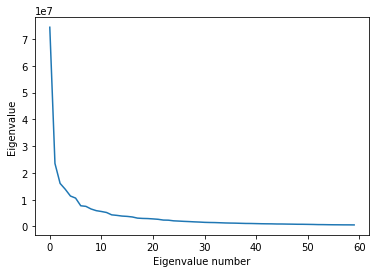

In [6]:
# plot eigenvalues
plt.plot(evals)
plt.xlabel('Eigenvalue number')
plt.ylabel('Eigenvalue')
plt.show()

**e. Projection and Reconstruction** An image $A$ can be represented in the space spanned by the top $k$ eigenvectors/principal components as follows:
$$P = C^T \cdot (A - \mu) \\ \text{where } P \text{ is } k \text{ x } 1 \text{ projection}
\\ \mu \text{ is } d \text{ x } 1 \text{ mean image vector}
\\ C \text{ is } d \text{ x } k \text{ matrix of k eigenvectors}$$

The projection $P$ can be used to reconstruct $A$ using the top $k$ eigenvectors/principal components follows:
$$R = C \cdot P + \mu \\ \text{where } R \text{ is } d \text{ x } 1 \text{ reconstruction}
\\ P \text{ is } k \text{ x } 1 \text{ projection}
\\ \mu \text{ is } d \text{ x } 1 \text{ mean image vector}
\\ C \text{ is } d \text{ x } k \text{ matrix of k eigenvectors}$$

Randomly select three images from the $X$ matrix. For each image, calculate its representation/projection in the space spanned by
1. top 10 eigenfaces
2. top 20 eigenfaces
3. top 30 eigenfaces
4. top 40 eigenfaces
5. top 50 eigenfaces
6. top 60 eigenfaces

In total, you should have computed 18 projections, 6 for each image.

Finally, from each projection, reconstruct the original image. Display the original images and the reconstructed images (you do not need to display the projections) using the [imshow](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.imshow.html) function from matplotlib.

In total, you should have computed 18 reconstructions, 1 from each projection.

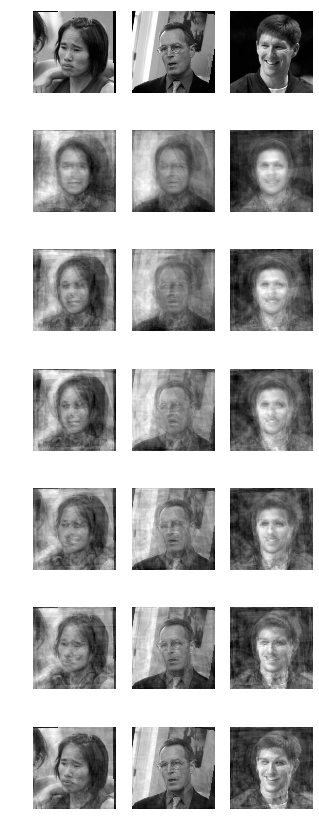

In [7]:
# number of images to project and reconstruct (i.e. "test")
num_imgs = 3

# indices in dataset of the images to test
imgs_idx = np.random.choice(images.shape[1], num_imgs, replace=False)

# figure for plotting the 1 original + 6 reconstructions for num_imgs images
fig, ax = plt.subplots(7, num_imgs, figsize=(5, 15))

for ii, idx in enumerate(imgs_idx):
    # get original image and its reconstruction using 10, 20, 30, 40, 50, 60 eigenfaces
    im = images[:, idx]
    im = im.reshape(-1, 1)

    # add original image to figure
    ax[0][ii].imshow(im.reshape(img_height, img_width), cmap="gray")
    ax[0][ii].axis('off')
    
    # project and reconstruct, adding the reconstructed image to axes for plotting
    for ci, num_comps in enumerate(range(10, 61, 10)):
        projection = evecs[:, :num_comps].T @ (im - mean_vec)
        reconstruction = evecs[:, :num_comps] @ projection + mean_vec
        reconstruction = reconstruction.reshape(img_height, img_width)

        ax[ci+1][ii].imshow(reconstruction, cmap="gray")
        ax[ci+1][ii].axis('off')

plt.show()

## Problem 3: Predicting Parkinson's

In this problem, we will be applying PCA to the [Parkinson's Disease Classification dataset](http://archive.ics.uci.edu/ml/datasets/Parkinson%27s+Disease+Classification)\[2\] and then performing classification using the k nearest neighbors algorithm. For this problem, please use functions from the scikit-learn library ([PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html), [KNearestNeighbors](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html), [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html), etc) 

In [8]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

**a. Prepare and Pre-process** Load the data `pd_speech_X.csv` and corresponding labels `pd_speech_Y.csv`. Normalize the data by subtracting mean and dividing by variance for each attribute/feature. Split the data and labels into training and testing sets using train/test ratio of 0.8/0.2

In [9]:
# load data
X = pd.read_csv('pd_speech_X.csv')
Y = pd.read_csv('pd_speech_Y.csv')
X.head()

,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,locAbsJitter,...,tqwt_kurtosisValue_dec_27,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36
0,1,0.85247,0.71826,0.57227,240,239,0.008064,0.000087,0.00218,0.000018,...,1.5466,1.5620,2.6445,3.8686,4.2105,5.1221,4.4625,2.6202,3.0004,18.9405
1,1,0.76686,0.69481,0.53966,234,233,0.008258,0.000073,0.00195,0.000016,...,1.5530,1.5589,3.6107,23.5155,14.1962,11.0261,9.5082,6.5245,6.3431,45.1780
2,1,0.85083,0.67604,0.58982,232,231,0.008340,0.000060,0.00176,0.000015,...,1.5399,1.5643,2.3308,9.4959,10.7458,11.0177,4.8066,2.9199,3.1495,4.7666
3,0,0.41121,0.79672,0.59257,178,177,0.010858,0.000183,0.00419,0.000046,...,6.9761,3.7805,3.5664,5.2558,14.0403,4.2235,4.6857,4.8460,6.2650,4.0603
4,0,0.32790,0.79782,0.53028,236,235,0.008162,0.002669,0.00535,0.000044,...,7.8832,6.1727,5.8416,6.0805,5.7621,7.7817,11.6891,8.2103,5.0559,6.1164


In [10]:
# preprocess
X = pd.read_csv('pd_speech_X.csv')
Y = pd.read_csv('pd_speech_Y.csv')
mean = X.mean()
variance = X.var()
X = (X - mean) / variance

In [11]:
# split into train and test set. seed rng for consistency
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=10)  

**b.** Using the train data and labels, train a k nearest neighbors model with k=3. Report the correct classification rate.

In [12]:
# apply knn
knn3_full = KNeighborsClassifier(n_neighbors=3)
knn3_full.fit(X_train, y_train['class'])

# test the model
y_test_preds_full = knn3_full.predict(X_test)
# conf_mat_full = confusion_matrix(y_test, y_test_preds_full)    # confusion matrix
print('Test CCR = {}'.format((y_test['class'] == y_test_preds_full).mean()))

Test CCR = 0.7697368421052632


**b.** Apply PCA (use number of components = 5) to the train data. Next, transform the train data to its representation in the lower dimensional space learned by the PCA model. Using this representation, train a k nearest neighbors classifier with k=3. Report the correct classification rate on the test data.

In [13]:
# pca using 5 components
pca = PCA(n_components=5)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [14]:
# apply knn on transformed data
knn3 = KNeighborsClassifier(n_neighbors=3)
knn3.fit(pca.transform(X_train), y_train['class'])

# test the model
y_test_preds = knn3.predict(pca.transform(X_test))
# conf_mat = confusion_matrix(y_test, y_test_preds)    # confusion matrix
print('Test CCR =', (y_test['class'] == y_test_preds).mean())

Test CCR = 0.743421052631579


## Citations
1. Gary B. Huang, Vidit Jain, and Erik Learned-Miller. Unsupervised joint alignment of complex images. International Conference on Computer Vision (ICCV), 2007.
2. Sakar, C.O., Serbes, G., Gunduz, A., Tunc, H.C., Nizam, H., Sakar, B.E., Tutuncu, M., Aydin, T., Isenkul, M.E. and Apaydin, H., 2018. A comparative analysis of speech signal processing algorithms for Parkinsonâ€™s disease classification and the use of the tunable Q-factor wavelet transform. Applied Soft Computing, DOI